- preprocess keywords file for term and categories

Term level analysis:
- preprocess abstract file for sentences
- apply w2v / fasttext
- co-occurrence
- do embedding analysis of wvs

Term-Doc analysis:
- term-doc representation

In [42]:
import pandas as pd
import numpy as np
import gensim as gs
from sklearn import metrics, manifold
from scipy import cluster
from sklearn import decomposition
import umap

import sys
sys.path.append('../')
import cogont as co

import matplotlib.pyplot as plt
from seaborn import despine
C_ORD = plt.rcParams['axes.prop_cycle'].by_key()['color']

font = {'family' : 'Arial',
        'weight' : 'regular',
        'size'   : 14}

plt.rc('font', **font)

In [2]:
datafolder = '../data/raw/cosyne2020/'
df_abs = pd.read_csv(datafolder+'Cosyne2020_abstracts_acceptedonly.csv', header=0, encoding="ISO-8859-1")
keywords = pd.read_csv(datafolder+'cosyne2020_keywords.csv')
# get keywords as dictionary with category:word list pairs
kw_dict, kw_inds = dict(), dict()
for i_k, curr_kw in keywords.iterrows():
    cat_pairs = curr_kw.values[0].split(',')
    for cp in cat_pairs:
        k, v = cp.lower()[1:].split('] ')
        if k in kw_dict.keys():
            kw_dict[k].append(v)
            kw_inds[k].append(i_k)
        else:
            kw_dict[k] = [v]
            kw_inds[k] = [i_k]
            
# break apart multi-word phrases to catch while scanning, they will be re-hyphenated later
for k in kw_dict.keys():
    kw_dict[k] = [' '.join(v.split('-')) for v in kw_dict[k]]

### Massaging the keywords 

In [3]:
# get all terms and category-term pairs for counting
terms = np.concatenate([v for k,v in kw_dict.items()])
kw_all = np.concatenate([[k+':'+vv for vv in v] for k,v in kw_dict.items()])

tc, count = np.unique(kw_all, return_counts=True)
count_sorted = np.argsort(count)[::-1]

terms_cat = np.array([t.split(':') for t in tc])
# save out keywords to term file
pd.DataFrame(np.hstack((terms_cat, count[:,None])), columns=['category', 'term', 'count']).to_csv(datafolder+'keywords.csv')

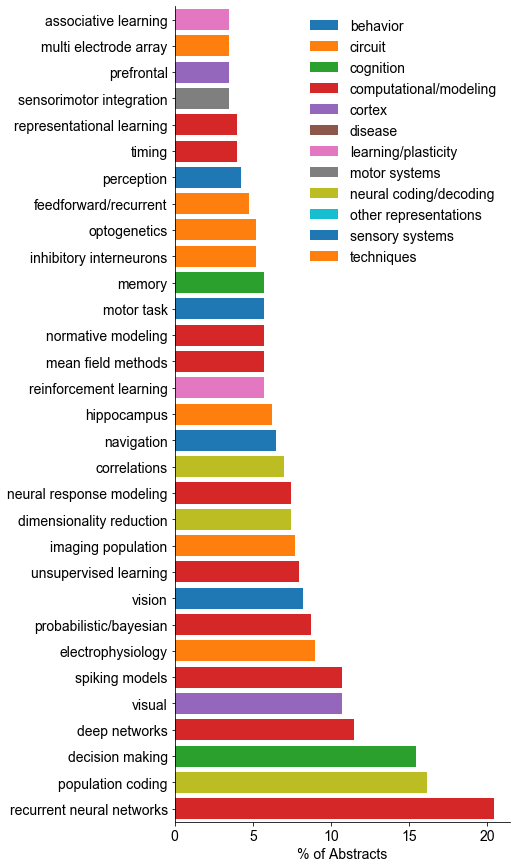

In [416]:
show_top_n = 30
df_kw = pd.read_csv(datafolder+'keywords.csv', index_col=0)
df_kw.sort_values('count', inplace=True, ascending=False, ignore_index=True)
df_kw['term_hyph'] = ['-'.join(i_t.split(' ')) for i_t in df_kw['term']]

plt.figure(figsize=(6,15))
for i_g, grp in df_kw.groupby('category'):
    plt.barh(grp.index, grp['count'].values/len(df_abs)*100, label=i_g)
    
plt.yticks(np.arange(len(df_kw)), df_kw['term'].values);
plt.ylim([-0.5, show_top_n+0.5]); despine()
plt.legend(frameon=False); plt.xlabel('% of Abstracts')
plt.savefig(datafolder+'topic_count.png', bbox_inches='tight')

# Learning word embedding of topics

In [111]:
terms = np.unique(terms_cat[:,1])

print('Converting to sentence-level representation.')
abs_stcs = co.doc_to_stcs(df_abs)
abs_stcs, terms_concat = co.concat_terms(abs_stcs, terms)

print('Training word2vec model.')
abs_w2v = gs.models.Word2Vec(abs_stcs, min_count=2, size=20, window=20, sg=1)
abs_w2v.init_sims()
abs_w2v_vocab = abs_w2v.wv.index2word # get the vocab of word2vec representation
abs_vecs = abs_w2v.wv.vectors

Converting to sentence-level representation.
Training word2vec model.


In [421]:
# do some queries with the model most_similar function, which looks at the whole corpus
top_n = 15

print('+++++++++++++++++++++++++++++++++++')
positive = ['dimensionality-reduction']
negative = []
print('Positives: ', positive, '\nNegatives: ', negative)

print('\n--- Search only within keyword terms: ---')
co.print_similarity(co.most_similar_subset(abs_w2v_vocab,terms_concat,abs_vecs,positive,negative,top_n))
print('\n--- Search overall: ---')
co.print_similarity(abs_w2v.wv.most_similar(positive, negative, topn=top_n))


print('+++++++++++++++++++++++++++++++++++')
positive = ['recurrent-neural-networks']
negative = ['dimensionality-reduction']
print('Positives: ', positive, '\nNegatives: ', negative)

print('\n--- Search only within keyword terms: ---')
co.print_similarity(co.most_similar_subset(abs_w2v_vocab,terms_concat,abs_vecs,positive,negative,top_n))
print('\n--- Search overall: ---')
co.print_similarity(abs_w2v.wv.most_similar(positive, negative, topn=top_n))


print('+++++++++++++++++++++++++++++++++++')
positive = ['manifolds', 'manifolds']
negative = []#['population-coding']
print('Positives: ', positive, '\nNegatives: ', negative)

print('\n--- Search only within keyword terms: ---')
co.print_similarity(co.most_similar_subset(abs_w2v_vocab,terms_concat,abs_vecs,positive,negative,top_n))
print('\n--- Search overall: ---')
co.print_similarity(abs_w2v.wv.most_similar(positive, negative, topn=top_n))

print('+++++++++++++++++++++++++++++++++++')
positive = ['oscillations']
negative = []#['population-coding']
print('Positives: ', positive, '\nNegatives: ', negative)

print('\n--- Search only within keyword terms: ---')
co.print_similarity(co.most_similar_subset(abs_w2v_vocab,terms_concat,abs_vecs,positive,negative,top_n))
print('\n--- Search overall: ---')
co.print_similarity(abs_w2v.wv.most_similar(positive, negative, topn=top_n))

+++++++++++++++++++++++++++++++++++
Positives:  ['dimensionality-reduction'] 
Negatives:  []

--- Search only within keyword terms: ---
----------------
 Similiarty
---------------
1.0000: dimensionality-reduction
0.9330: recurrent-neural-networks
0.9289: optogenetics
0.9238: fmri
0.9123: amygdala
0.9088: barrel
0.9049: generative-models
0.8912: deep-networks
0.8878: linear-models
0.8873: timing
0.8823: oculomotor
0.8785: motor-task
0.8726: electrophysiology
0.8700: unsupervised-learning
0.8656: population-coding

--- Search overall: ---
----------------
 Similiarty
---------------
0.9822: synthetic
0.9728: multivariate
0.9705: deconvolution
0.9679: compare
0.9672: identify
0.9658: apply
0.9658: simulation
0.9655: variational
0.9655: examine
0.9640: built
0.9626: measure
0.9616: obtained
0.9615: constructed
0.9607: truth
0.9601: inferring
+++++++++++++++++++++++++++++++++++
Positives:  ['recurrent-neural-networks'] 
Negatives:  ['dimensionality-reduction']

--- Search only within keywo

In [400]:
# do some queries with the model most_similar function, which looks at the whole corpus
top_n = 10



--- Search only within keyword terms: ---
Positives:  ['manifolds', 'manifolds'] | Negatives:  []
----------------
 Similiarty
---------------
0.9658: deep-networks
0.9645: linear-models
0.9639: cerebellum
0.9592: population-coding
0.9533: grid-cells
0.9513: fmri
0.9488: biophysics
0.9432: basal-ganglia
0.9409: barrel
0.9397: oculomotor

--- Search overall: ---
Positives:  ['manifolds', 'manifolds'] | Negatives:  []
----------------
 Similiarty
---------------
0.9903: relates
0.9889: wm
0.9888: isolate
0.9867: characteristics
0.9862: maladaptive
0.9850: subspaces
0.9832: matrices
0.9830: interacting
0.9824: assess
0.9824: evaluate


# 2D projection
With PCA and UMAP 

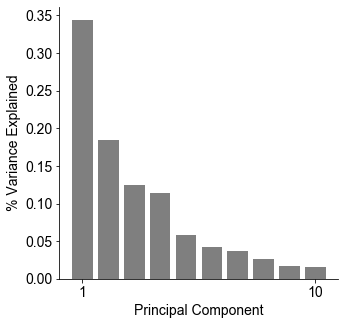

In [422]:
subset_inds = co.return_subset_inds(abs_w2v_vocab, terms_concat)
plt.figure(figsize=(5,5))
n_pc = 10
abs_pca = decomposition.PCA(n_pc)
projection = abs_pca.fit_transform(abs_w2v.wv.vectors_norm[subset_inds])[:,:2]
plt.bar(range(n_pc), abs_pca.explained_variance_ratio_, color='k', alpha=0.5)
plt.xticks([0,9], ['1','10']); plt.xlabel('Principal Component'); plt.ylabel('% Variance Explained')
despine()
plt.savefig(datafolder+'pc_var.png', bbox_inches='tight')

In [401]:
# condense keywork list
df_kw_collapse = pd.DataFrame(columns=df_kw.columns)
df_kw[df_kw['term']=='other']
for i_t, grp in df_kw.groupby('term'):
    if len(grp)==1:
        df_kw_collapse = df_kw_collapse.append(grp.sum(), ignore_index=True)
    else:
        df_curr = pd.DataFrame({'category': 'other', 'term': i_t, 'count': grp['count'].sum(), 'term_hyph':grp['term_hyph'].iloc[0]}, index=[0])        
        df_kw_collapse = df_kw_collapse.append(df_curr, ignore_index=True)
        


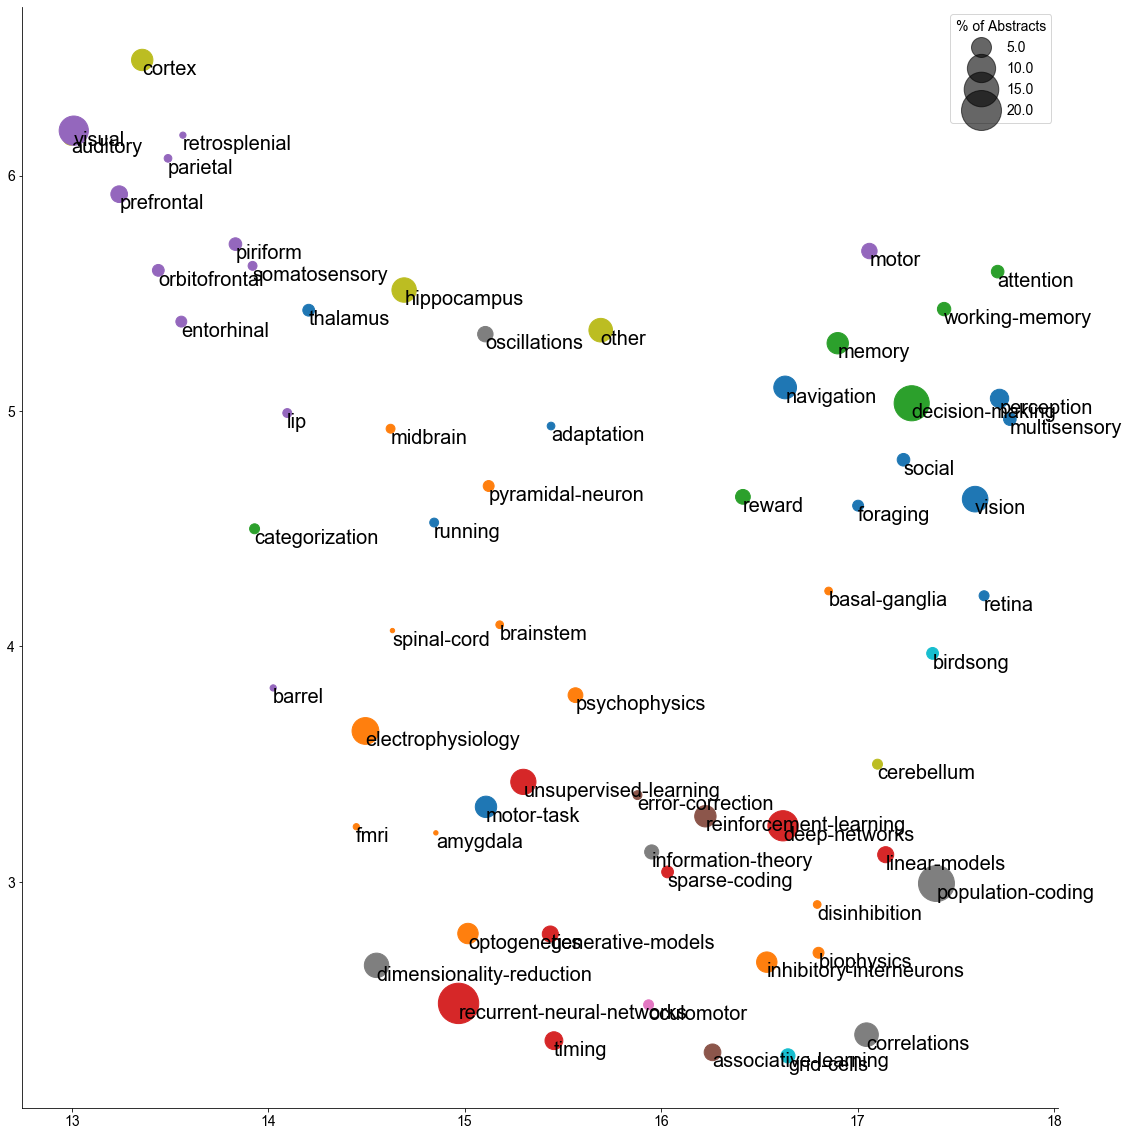

In [406]:
kw_sizes = np.array([df_kw_collapse[df_kw_collapse['term_hyph']==kw]['count'].values[0] for kw in np.array(abs_w2v_vocab)[subset_inds]])
kw_colors = np.array([df_kw_collapse[df_kw_collapse['term_hyph']==kw]['category'].values[0] for kw in np.array(abs_w2v_vocab)[subset_inds]])
kw_colors = np.hstack([C_ORD,C_ORD])[np.unique(kw_colors, return_inverse=True)[1]]

mag_x = 80
projection = umap.UMAP().fit_transform(abs_w2v.wv.vectors_norm[subset_inds])
#projection = manifold.TSNE(n_components=2).fit_transform(abs_w2v.wv.vectors_norm[subset_inds])

n_to_label = len(subset_inds)
top_inds, top_counts, top_terms = co.get_top_terms(abs_w2v, terms_concat, topn=n_to_label)        

plt.figure(figsize=(16,16))
#plt.scatter(projection[:,0], projection[:,1], s=100, c='k', alpha=0.5, marker='o')
scatter = plt.scatter(projection[:,0], projection[:,1], s=(kw_sizes/len(df_abs)*100*mag_x).astype(int), c=kw_colors, alpha=1, marker='o')
for t_i, t in enumerate(top_terms):
    # do some more gymnastics to get equivalent index in the subset
    s_i = subset_inds.index(top_inds[t_i])
    plt.text(projection[s_i,0], projection[s_i,1], t, ha="left", va="top", rotation=0, fontsize=20)

despine()
plt.tight_layout()

# produce a legend with a cross section of sizes from the scatter
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
plt.legend(handles[1::2], [int(l[14:-2])/mag_x for l in labels][1::2], title="% of Abstracts")
plt.savefig(datafolder+'umap.png', bbox_inches='tight')

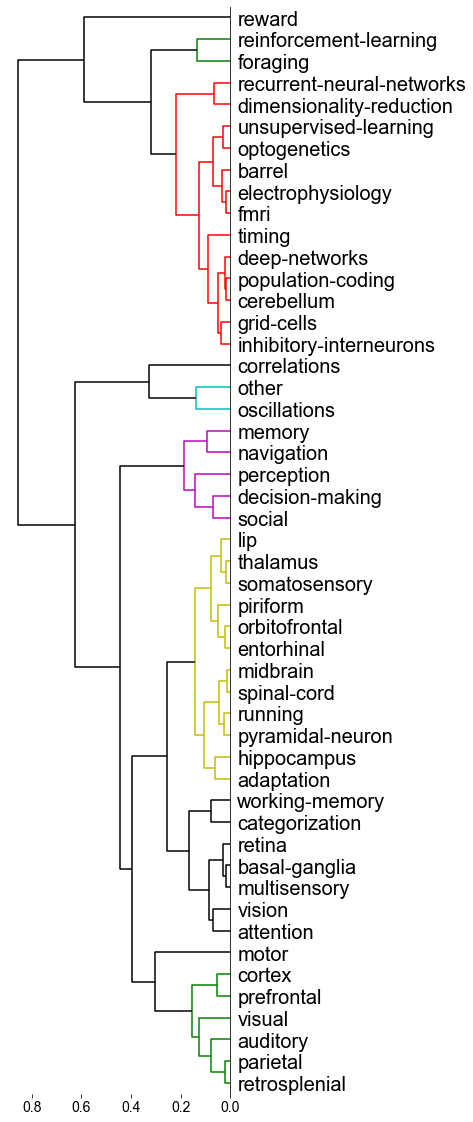

In [415]:
plt.figure(figsize=(4,20))
top_inds, top_counts, top_terms = co.get_top_terms(abs_w2v, terms_concat, topn=50)

# clustering
Y = cluster.hierarchy.linkage(abs_w2v.wv.vectors_norm[top_inds], method='complete', metric='cosine')
Z = cluster.hierarchy.dendrogram(Y,
               color_threshold=0.25,
               orientation='left',
               labels=top_terms,
               leaf_font_size=20,
               above_threshold_color='k')
plt.gca().invert_yaxis(); co.remove_spines(plt.gca(),['top','left', 'bottom'])
plt.savefig(datafolder+'hierarchical.png', bbox_inches='tight')